In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import EngFormatter
import cooler
import os
from itertools import product
import matplotlib.colors as mcol


bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)


In [2]:
data_before = np.load('data/RaoHiC/chr22_40kb.npz')['hic']
data_after = np.load('data/RaoHiC/enhanced_chr22_40kb.npz')['deephic']
data_real = np.load('data/RaoHiC/mat/GM12878/chr22_10kb.npz')['hic']

In [3]:
#染色体长度list
chr_list = pd.read_csv("/share/home/mliu/sc_sv/ref_data/hg19.chrom.sizes.txt",sep="\t",header=None)
chr_list.columns=['chr','len']

In [4]:
# chr = "chr1"
# fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)
# chr_len = chr_list.query('chr==@chr')['len'].values[0]
# fig,ax = plt.subplots(figsize=(30,10),ncols=3)
# im = ax[0].matshow(
#     data_before,
#     vmin=0,
#     vmax=10,
#     extent=(0,chr_len, chr_len, 0),
#     cmap=fruitpunch)
# plt.colorbar(im, ax=ax[0] ,fraction=0.046, pad=0.04, label='raw counts');
# #title
# ax[0].set_title(f'{chr} downsample',fontsize=15)
# format_ticks(ax[0])
# im = ax[1].matshow(
#     data_after,
#     vmin=0,
#     vmax=0.3,
#     extent=(0,chr_len, chr_len, 0),
#     cmap=fruitpunch)
# plt.colorbar(im, ax=ax[1] ,fraction=0.046, pad=0.04, label='raw counts');
# ax[1].set_title(f'{chr} imputed',fontsize=15)
# format_ticks(ax[1])

# im = ax[2].matshow(
#     data_real,
#     vmin=0,
#     vmax=20,
#     extent=(0,chr_len, chr_len, 0),
#     cmap=fruitpunch
# )
# ax[2].set_title(f'{chr} real',fontsize=15)
# format_ticks(ax[2])
# plt.colorbar(im, ax=ax[2] ,fraction=0.046, pad=0.04, label='raw counts');
# #设置整个画布的标题

# plt.show()

单细胞

In [7]:
#chr22
cool_dir = "../../cool/k562"
cell_name = "k5620123041102"
cell_name_enhanced = cell_name[6:]
chr = "chr1"
resolution = 20000
#一个单细胞的

sc_cool = cooler.Cooler(f"{cool_dir}/{cell_name}.mcool::/resolutions/{resolution}")
sc_matrix_raw = sc_cool.matrix(balance=False).fetch(chr)
print("raw shape",sc_matrix_raw.shape)

#读取enhanced之后的
sc_matrix_enhanced = np.load(f"data/sc/predict/enhanced_{resolution}_{cell_name_enhanced}_{chr}.npz")['deephic']
print("enhanced shape",sc_matrix_enhanced.shape)

raw shape (12463, 12463)
enhanced shape (12463, 12463)


In [8]:
fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)
chr_len = chr_list.query('chr==@chr')['len'].values[0]


def plot_raw_enhanced(matrix_raw,matrix_enhanced,vmax1,vmax2,start,end):
    fig,ax = plt.subplots(figsize=(20,10),ncols=2)
    im = ax[0].matshow(
        matrix_raw,
        vmin=0,
        vmax=vmax1,
        extent=(0,end, end, 0),
        cmap=fruitpunch)
    plt.colorbar(im, ax=ax[0] ,fraction=0.046, pad=0.04, label='raw counts');
    #title
    ax[0].set_title(f'{chr} raw',fontsize=15)
    format_ticks(ax[0])
    im = ax[1].matshow(
        matrix_enhanced,
        vmin=0,
        vmax=vmax2,
        extent=(0,end, end, 0),
        cmap=fruitpunch)
    plt.colorbar(im, ax=ax[1] ,fraction=0.046, pad=0.04, label='enhanced');
    ax[1].set_title(f'{chr} imputed',fontsize=15)
    format_ticks(ax[1])
    plt.show()

In [9]:

def get_sum_from_matrix_list(dir,matirx_list,tag='deephic'):
    sc_chr_matrix = []
    for i in range(len(matirx_list)):
        sc_chr_matrix.append(np.load(os.path.join(dir,matirx_list[i]))[tag])
    sc_chr_matrix = np.array(sc_chr_matrix)
    sc_chr_matrix_sum = np.sum(sc_chr_matrix,axis=0)
    return sc_chr_matrix_sum

In [10]:
chr_fetch = chr+"."
matrix_dir = "/share/home/mliu/sc_sv/imputation/DeepHiC/data/sc/predict"
matirx_list = os.listdir(matrix_dir)
matirx_list_chr = [i for i in matirx_list if chr_fetch in i if str(resolution) in i]
matirx_list_chr

['enhanced_20000_23041101_chr1.npz',
 'enhanced_20000_23041102_chr1.npz',
 'enhanced_20000_23041104_chr1.npz',
 'enhanced_20000_23041105_chr1.npz',
 'enhanced_20000_23041106_chr1.npz',
 'enhanced_20000_23041113_chr1.npz',
 'enhanced_20000_23041114_chr1.npz',
 'enhanced_20000_23041115_chr1.npz',
 'enhanced_20000_23041117_chr1.npz',
 'enhanced_20000_23041118_chr1.npz']

In [11]:
sum_matrix_enhanced = get_sum_from_matrix_list(matrix_dir,matirx_list_chr,tag="deephic")

In [12]:
def get_sc_sum_from_cool(cool_dir,cool_name,chr,resolution):
    sc_chr_matrix = []
    for i in range(len(cool_name)):
        file = os.path.join(cool_dir,cool_name[i])
        clr = cooler.Cooler(f"{file}::/resolutions/{resolution}")
        matrix = clr.matrix(balance=False).fetch(chr)
        sc_chr_matrix.append(matrix)
    sc_chr_matrix = np.array(sc_chr_matrix)
    sc_chr_matrix_sum = np.sum(sc_chr_matrix,axis=0)
    return sc_chr_matrix_sum
cool_dir = "/share/home/mliu/sc_sv/imputation/DeepHiC/data/sc/cool"
cool_name = os.listdir(cool_dir)
sum_matrix_raw = get_sc_sum_from_cool(cool_dir,cool_name,chr,resolution)

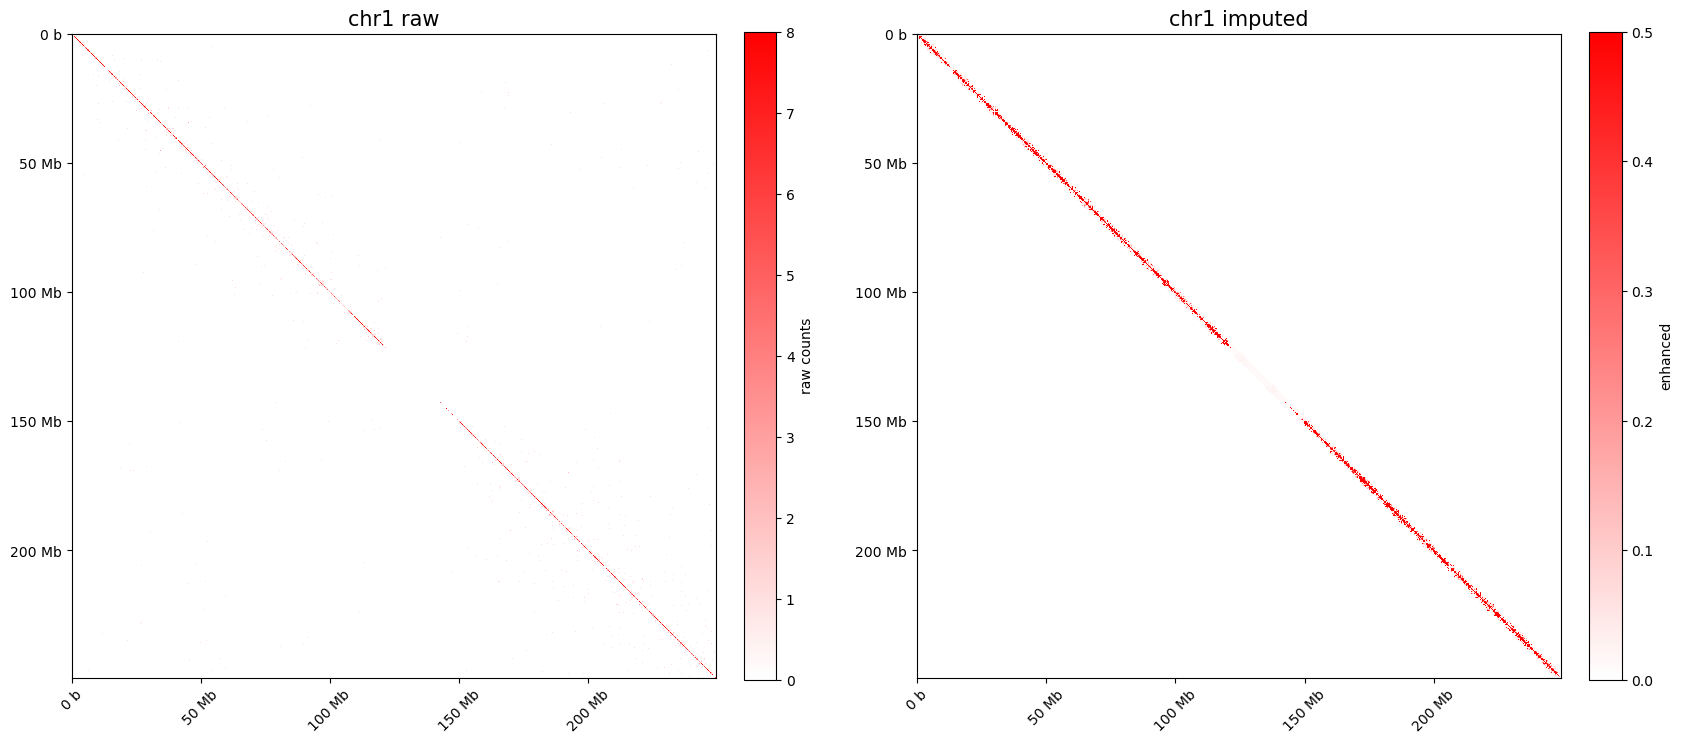

In [13]:
start = 0
end = chr_len
matrix_raw = sc_matrix_raw
matrix_enhanced = sc_matrix_enhanced
vmax1 = 8
vmax2 = 0.5
plot_raw_enhanced(sum_matrix_raw,sum_matrix_enhanced,vmax1,vmax2,start,end)

In [ ]:
#k562
resolution_bulk = 25000
K562_bulk_cool_path = f"/share/home/mliu/sc_sv/raw_data/K562/4DNFI18UHVRO.mcool::/resolutions/{resolution_bulk}"
K562_bulk_clr = cooler.Cooler(K562_bulk_cool_path)
chr_list = pd.read_csv("/share/home/mliu/sc_sv/ref_data/hg19.chrom.sizes.txt",sep="\t",header=None)
chr_list.columns=['chr','len']
chr_len = chr_list.query('chr==@chr')['len'].values[0]
whole_matrix = K562_bulk_clr.matrix(balance=False).fetch(chr)

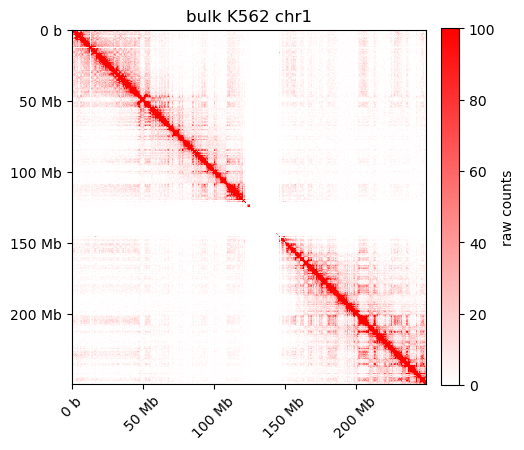

In [34]:
fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)
fig,ax = plt.subplots(figsize=(5,5))
im = ax.matshow(
    whole_matrix,
    vmin=0,
    vmax=100,
    extent=(0,chr_len, chr_len, 0),
    cmap=fruitpunch)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
plt.title(f"bulk K562 {chr}")
format_ticks(ax)

In [3]:
cmap = mcol.LinearSegmentedColormap.from_list('custom_red', [(0, 'white'), (0.15, 'white'), (1, '#e60000')], N=256)

In [40]:
def matrix_reader(cool_path, chrom, res, iced, chrom2=None):
    print("cool_handle")
    print(cool_path + "::/resolutions/" + str(res))
    cool_handle = cooler.Cooler(cool_path + "::/resolutions/" + str(res)) 
    cool_matrix = cool_handle.matrix(balance=iced).fetch (chrom)[:] 
    if chrom2 is not None: 
         cool_matrix = cool_handle.matrix(balance=iced).fetch (chrom, chrom2)[:] 
    else: 
        np.fill_diagonal(cool_matrix, 0) 
    np.nan_to_num(cool_matrix, copy=False) 
    return cool_matrix

In [18]:
def concat_matrix(cool_path, c1, o1, c2, o2, res, iced): 
    m1 = matrix_reader(cool_path, c1, res, iced) 
    m2 = matrix_reader(cool_path, c2, res, iced) 
    mi = matrix_reader(cool_path, c1, res, iced, chrom2=c2) 
    nrow_1 = m1.shape[0] 
    nrow_2 = m2.shape[0] 
    nrow_cm = nrow_1 + nrow_2 
    cm = np.zeros((nrow_cm, nrow_cm)) 
    if o1 + o2 == "+-": 
        pass 
    elif o1 + o2 == "++":
        m2 = np.flip(np.flip(m2, 0), 1) 
        mi = np.flip(mi, 1) 
    elif o1 + o2 == "--":
        m1 = np.flip(np.flip(m1, 0), 1) 
        mi = np.flip(mi, 0) 
    elif o1 + o2 == "-+": 
        m1 = np.flip(np.flip(m1, 0), 1) 
        m2 = np.flip(np.flip(m2, 0), 1) 
        mi = np.flip(np.flip(mi, 0), 1) 
    cm[0:nrow_1, 0:nrow_1] = m1 
    cm[nrow_1:nrow_cm, nrow_1:nrow_cm] = m2
    cm[0:nrow_1, nrow_1:nrow_cm] = mi * 2 
    cm[nrow_1:nrow_cm, 0:nrow_1] = np.rot90(np.flip(mi, 1), 1) * 2 
    return cm

In [36]:
def concat_tri(fig, ax, mat, c1, o1, c2, o2, res, cmap, title=None, xlabel=None, ylabel=None): 
    n = mat.shape[0] 
    t = np.array([[1, 1], [-1, 1]])
    A = np.dot(np.array([(i[1], i[0]) for i in product(range(n +1), range(n+1))]), t) 
    vmax = np.percentile(mat, 92) 
    if vmax == 0: 
        while vmax == 0 and (perc - 5) > 0: 
            perc = perc - 5 
            vmax = np.percentile(mat, perc) 
    vmin = np.min(mat) 
    img = ax.pcolormesh(A[:, 1].reshape(n+1, n+1), A[:, 0]. reshape(n+1, n+1), mat, cmap=cmap, vmax=vmax, vmin=vmin) 
    img.set_rasterized(True) 
    ax.set_frame_on(False) 
    ax.set_ylim([0, n]) 
    ax.set_aspect(1) 
    ax.yaxis.set_visible(False)

    # set ticks 
    merge_point = 2 * (c1[2] - c1[1] ) // res 
    ticks = [0, merge_point // 2, merge_point, merge_point//2+n, 2*n] 
    ax.set_xticks(ticks) 
    # set labels 
    ax.set_xticklabels(["", c1[0], "", c2[0], ""], size=16)

                       # ax title 
    title = f"{c1[0]}:{c1[1]}-{c1[2]}({o1})\n{c2[0]}:{c2[1]}-{c2 [2]}({o2})"
    ax.set_title(title, pad=20, size=15) 
    if xlabel != None: 
        ax.set_xlabel(xlabel, labelpad=10, fontsize=15)

    if ylabel != None: 
        ax.set_ylabel(ylabel, labelpad=10, fontsize=15) 
    # set color bar 
    pos0 = ax.get_position() 
    cax = fig.add_axes([pos0.x0+pos0.width*0.9, pos0.y0+pos0. height*0.8, pos0.width*0.01, pos0.height*0.2]) 
    cbar = fig.colorbar(img, cax=cax, ticks=[vmin, vmax]) 
    cbar.ax.set_yticklabels([f"{vmin:.1f}", f"{vmax:.1f}"], fontsize=12) 
    # add an arrow/dashed line at the merge_point 
    xmin, xmax, ymin, _ = ax.axis() 
    x1, y1 = xmin + merge_point, ymin 
    x2, y2 = xmin + merge_point/2, ymin + merge_point/2 
    x3, y3 = x1 + (xmax-xmin-merge_point)/2, ymin + (xmax-xmin-merge_point)/2 
    ax.plot((x1, x2), (y1, x2), linestyle=':', linewidth=2, color="black") 
    ax.plot((x1, x3), (y1, y3), linestyle=':', linewidth=2, color="black") 
    return None

In [37]:
def plotHiC_SV(clr, c1, c2, w, res, iced=False): 
    o1 = c1[2] 
    o2 = c2[2] 
    if o1 == "+": 
        start = 0 if (c1[1] - w) < 0 else (c1[1] - w) 
        end = c1[1] 
    else: 
        start = c1[1] 
        end = c1[1] + w 
    c1 = (c1[0], start, end) 
    if o2 == "+": 
        start = 0 if (c2[1] - w) < 0 else (c2[1] - w) 
        end = c2[1] 
    else: 
        start = c2[1] 
        end = c2[1] + w 
    c2 = (c2[0], start, end) 
    mat = concat_matrix(clr, c1, o1, c2, o2, res, iced) 
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.3), constrained_layout=True) 
    concat_tri(fig, ax, mat, c1, o1, c2, o2, res, cmap=cmap) 
    plt.show()

cool_handle
/share/home/mliu/sc_sv/raw_data/K562/4DNFI18UHVRO.mcool::/resolutions/100000
cool_handle
/share/home/mliu/sc_sv/raw_data/K562/4DNFI18UHVRO.mcool::/resolutions/100000
cool_handle
/share/home/mliu/sc_sv/raw_data/K562/4DNFI18UHVRO.mcool::/resolutions/100000


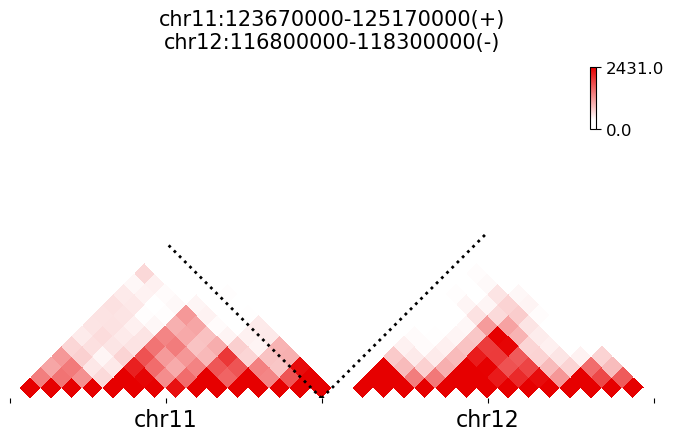

In [44]:
clr_path = '/share/home/mliu/sc_sv/raw_data/K562/4DNFI18UHVRO.mcool'
plotHiC_SV(clr_path,('chr11', 125170000, '+'), ('chr12', 116800000, '-'), w=1500000, res=100000)